# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.datasets import make_classification
sns.set(style="darkgrid")
print("install end")

install end


In [2]:
print("Hello world!")

Hello world!


## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### найдем производную сигмоидной функции

#### $$\frac{d\sigma}{dz} = \sigma(z)(1 - \sigma(z))
$$

#### Сразу реализуем сигмоидную функцию активации 
$$ \frac{1}{e^{-value} + 1}$$


In [3]:
def sigmoid(value):
    return 1 / (1 + np.exp(-value))

#### Тогда градиент логистической части функции потерь по весу w_j для j-го признака будет:
$$\frac{\partial L}{\partial w_j} = \sum_{i=1}^{N} (y_i - \sigma(w^T x_i))x_{ij}$$
#### Градиент регуляризационной части L1(Lasso) по весу w_j
$$\frac{\partial}{\partial w_j} \gamma \|w\|_1 = \gamma \cdot \text{sign}(w_j)
$$
#### Градиент регуляризационной части L2(Ridge) по весу w_j
$$\frac{\partial}{\partial w_j} \beta \|w\|^2_2 = 2 \cdot \beta \cdot w_j
$$
#### Объединяем:
$$\nabla_w L(w) = \sum_{i=1}^{N} (y_i - \sigma(w^T x_i))x_{i} + \gamma \cdot \text{sign}(w) + 2 \cdot \beta \cdot w
$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [4]:
#def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
def loss(X, y, w:List[float], gamma=1.0, beta=1.0):
    w = np.array(w)
    
    predictions = sigmoid(np.dot(X, w))
    
    log_loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    
    l1_penalty = gamma * np.sum(np.abs(w))
    
    l2_penalty = beta * np.sum(w ** 2)
    
    total_loss = log_loss + l1_penalty + l2_penalty
    return total_loss


#### 3. [0.25 points] Implement the gradient (as a function)

### Возвращаемся к пункту 1:
$$\nabla_w L(w) = \sum_{i=1}^{N} (y_i - \sigma(w^T x_i))x_{i} + \gamma \cdot \text{sign}(w) + 2 \cdot \beta \cdot w
$$

In [5]:
#def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
#    grad_w = #...

#    return grad_w

def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    sigma = sigmoid(np.dot(X, w))
    grad_result = np.dot(X.T, (sigma - y)) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_result

#### Check yourself

In [6]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)
print("Hi PAul!")

Hi PAul!


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42, threshold=0.65):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.lr = lr
        self.threshold = threshold # added a parameter for comparison
        self.random_state = random_state
        self.w = None
        self.loss_history = None
        self.threshold = threshold
        # you may additional properties if you wish

    def fit(self, X, y):
        # Ensure input features include the bias term
        print(np.ones(X.shape[0]).reshape(-1, 1).shape, X.shape)
        X_with_bias = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
    
        # Initialize model parameters if they haven't been already
        self.w = self.w or np.random.normal(scale=0.1, size=X_with_bias.shape[1])
    
        self.loss_history = []
        iteration = 0
        converged = False
    
        # convergence check
        while iteration < self.max_iter and not converged:
            current_w = self.w.copy()
        
            # Calculate gradient and update weights
            grad = self.compute_gradient(X_with_bias, y)
            self.w -= self.lr * grad
        
            # Record loss for the current iteration
            current_loss = self.compute_loss(X_with_bias, y)
            self.loss_history.append(current_loss)
        
            iteration += 1
            # Check convergence
            converged = np.linalg.norm(self.w - current_w) <= self.tolerance

        return self

    def predict(self, X):
        # Make sure the model has been trained before making predictions
        if self.w is None:
            raise ValueError("The model must be trained before making predictions.")
        
        X = np.c_[np.ones(X.shape[0]), X]

        # Compute the probabilities using the sigmoid function
        probabilities = sigmoid(np.dot(X, self.w))

        # Assign class labels based on the probability threshold
        predictions = (probabilities >= self.threshold).astype(int)

        return predictions
    
    def compute_gradient(self, X, y):
        l1 = np.dot(self.gamma, np.sign(self.w))
        l2 = np.dot(2*self.beta, self.w)
        # y_pred = self._predict(X)
        y_pred = sigmoid(np.dot(X, self.w))
        return np.add(l1, np.add(l2, np.dot(np.transpose(X), np.subtract(y_pred, y))))

    def compute_loss(self, X, y):
        y_pred = sigmoid(np.dot(X, self.w))
        temp = np.dot(1 - y, np.log(1 - y_pred))
        trash = np.sum(np.dot(y, np.log(y_pred)))
        # l1 + l2 - ...
        return self.gamma*np.sum(np.abs(self.w)) + self.beta*np.sum(np.square(self.w)) - trash + temp
    
    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return np.array([1 / (np.exp(np.dot(X, self.w)) + 1),\
                         1 / (np.exp(-np.dot(X, self.w)) + 1)])

In [9]:
# sample data to test your model
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

print("computed!")

computed!


In [10]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y, title = ''):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(title)
    

(180, 1) (180, 2)


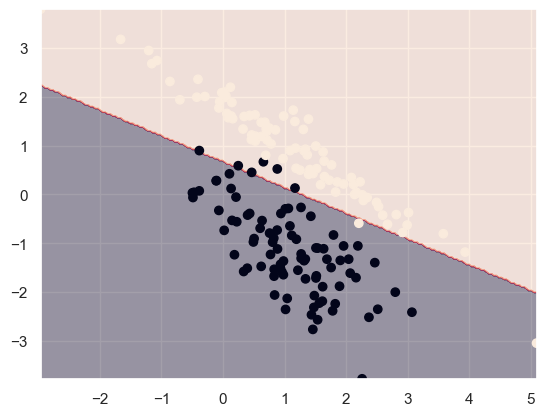

In [11]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

### Я сранивал бинарную классификацию на разных порогах [0.5;1] и самые лучшие показатели на мой взгляд дал threshold = 0.65

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

In [12]:
def plot_loss_diagram(loss_history):
    plt.figure(figsize=(4, 4))
    plt.plot(loss_history, label='Loss over iterations')
    plt.title('Loss Diagram')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



plot_loss_diagram(mock_loss_history)

NameError: name 'mock_loss_history' is not defined

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from functools import partial

from sklearn.preprocessing import StandardScaler

#создадим выборку для классификации и разобьем на трейн и тест
X, y = make_classification(n_samples=1024, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#будем нормализовать данные по статистикам трейна
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#создадим lists с обученными на трейне моделями в зависимости от ядра и коэф регуляризации
С_linspace = np.linspace(0.18, 4., 100)

Linear_kernel_SVMs = [SVC(C = c, kernel='linear', probability=True, random_state=42).fit(X_train, y_train) for c in С_linspace]
Polynomial_kernel_SVMs = [SVC(C = c, kernel='poly', probability=True, random_state=42, degree=3, coef0 = 0.5).fit(X_train, y_train) for c in С_linspace]
RBF_kernel_SVMs = [SVC(C = c, kernel='rbf', probability=True, random_state=42).fit(X_train, y_train) for c in С_linspace]

In [14]:
#создадим массивы со значениями метрик на трейне и тесте, для краткости и читабельности используем partial из functools

acc, roc_auc, f1 = partial(accuracy_score, y_test), partial(roc_auc_score, y_test), partial(f1_score, y_test)

Linear_scores_test = np.array([(acc(svc.predict(X_test)), roc_auc(svc.predict_proba(X_test)[:, 1]), f1(svc.predict(X_test))) for svc in Linear_kernel_SVMs])
Polynomial_scores_test = np.array([(acc(svc.predict(X_test)), roc_auc(svc.predict_proba(X_test)[:, 1]), f1(svc.predict(X_test))) for svc in Polynomial_kernel_SVMs])
RBF_scores_test = np.array([(acc(svc.predict(X_test)), roc_auc(svc.predict_proba(X_test)[:, 1]), f1(svc.predict(X_test))) for svc in RBF_kernel_SVMs])

acc, roc_auc, f1 = partial(accuracy_score, y_train), partial(roc_auc_score, y_train), partial(f1_score, y_train)

Linear_scores_train = np.array([(acc(svc.predict(X_train)), roc_auc(svc.predict_proba(X_train)[:, 1]), f1(svc.predict(X_train))) for svc in Linear_kernel_SVMs])
Polynomial_scores_train = np.array([(acc(svc.predict(X_train)), roc_auc(svc.predict_proba(X_train)[:, 1]), f1(svc.predict(X_train))) for svc in Polynomial_kernel_SVMs])
RBF_scores_train = np.array([(acc(svc.predict(X_train)), roc_auc(svc.predict_proba(X_train)[:, 1]), f1(svc.predict(X_train))) for svc in RBF_kernel_SVMs])

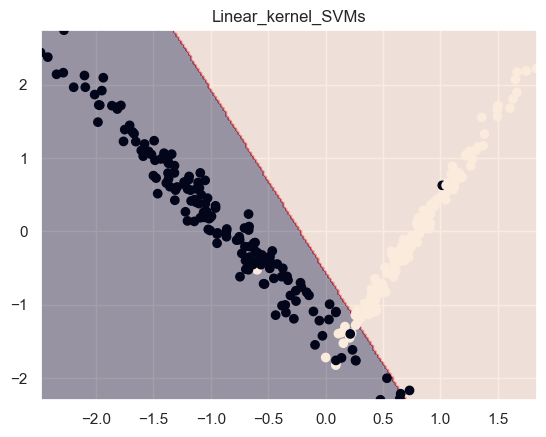

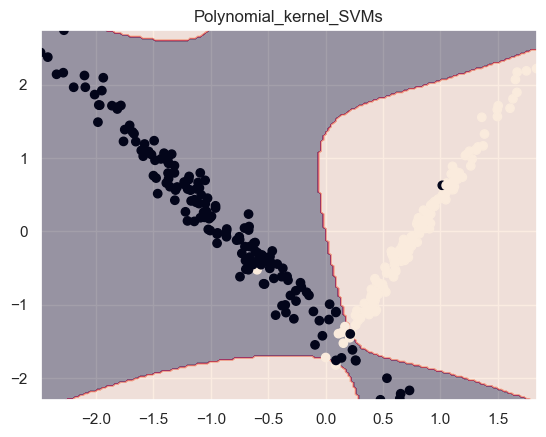

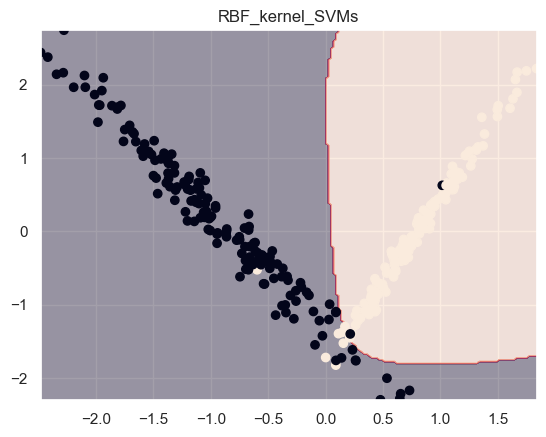

In [15]:
from sklearn.pipeline import make_pipeline

#визуализация для лучших значений по accuracy
best_linear_C_idx = np.argmax(Linear_scores_test[:, 0])
best_poly_C_idx = np.argmax(Polynomial_scores_test[:, 0])
best_rbf_C_idx = np.argmax(RBF_scores_test[:, 0])

plot_decision_boundary(Linear_kernel_SVMs[best_linear_C_idx], X_test, y_test, 'Linear_kernel_SVMs')
plot_decision_boundary(Polynomial_kernel_SVMs[best_poly_C_idx], X_test, y_test, 'Polynomial_kernel_SVMs')
plot_decision_boundary(RBF_kernel_SVMs[best_rbf_C_idx], X_test, y_test, 'RBF_kernel_SVMs')

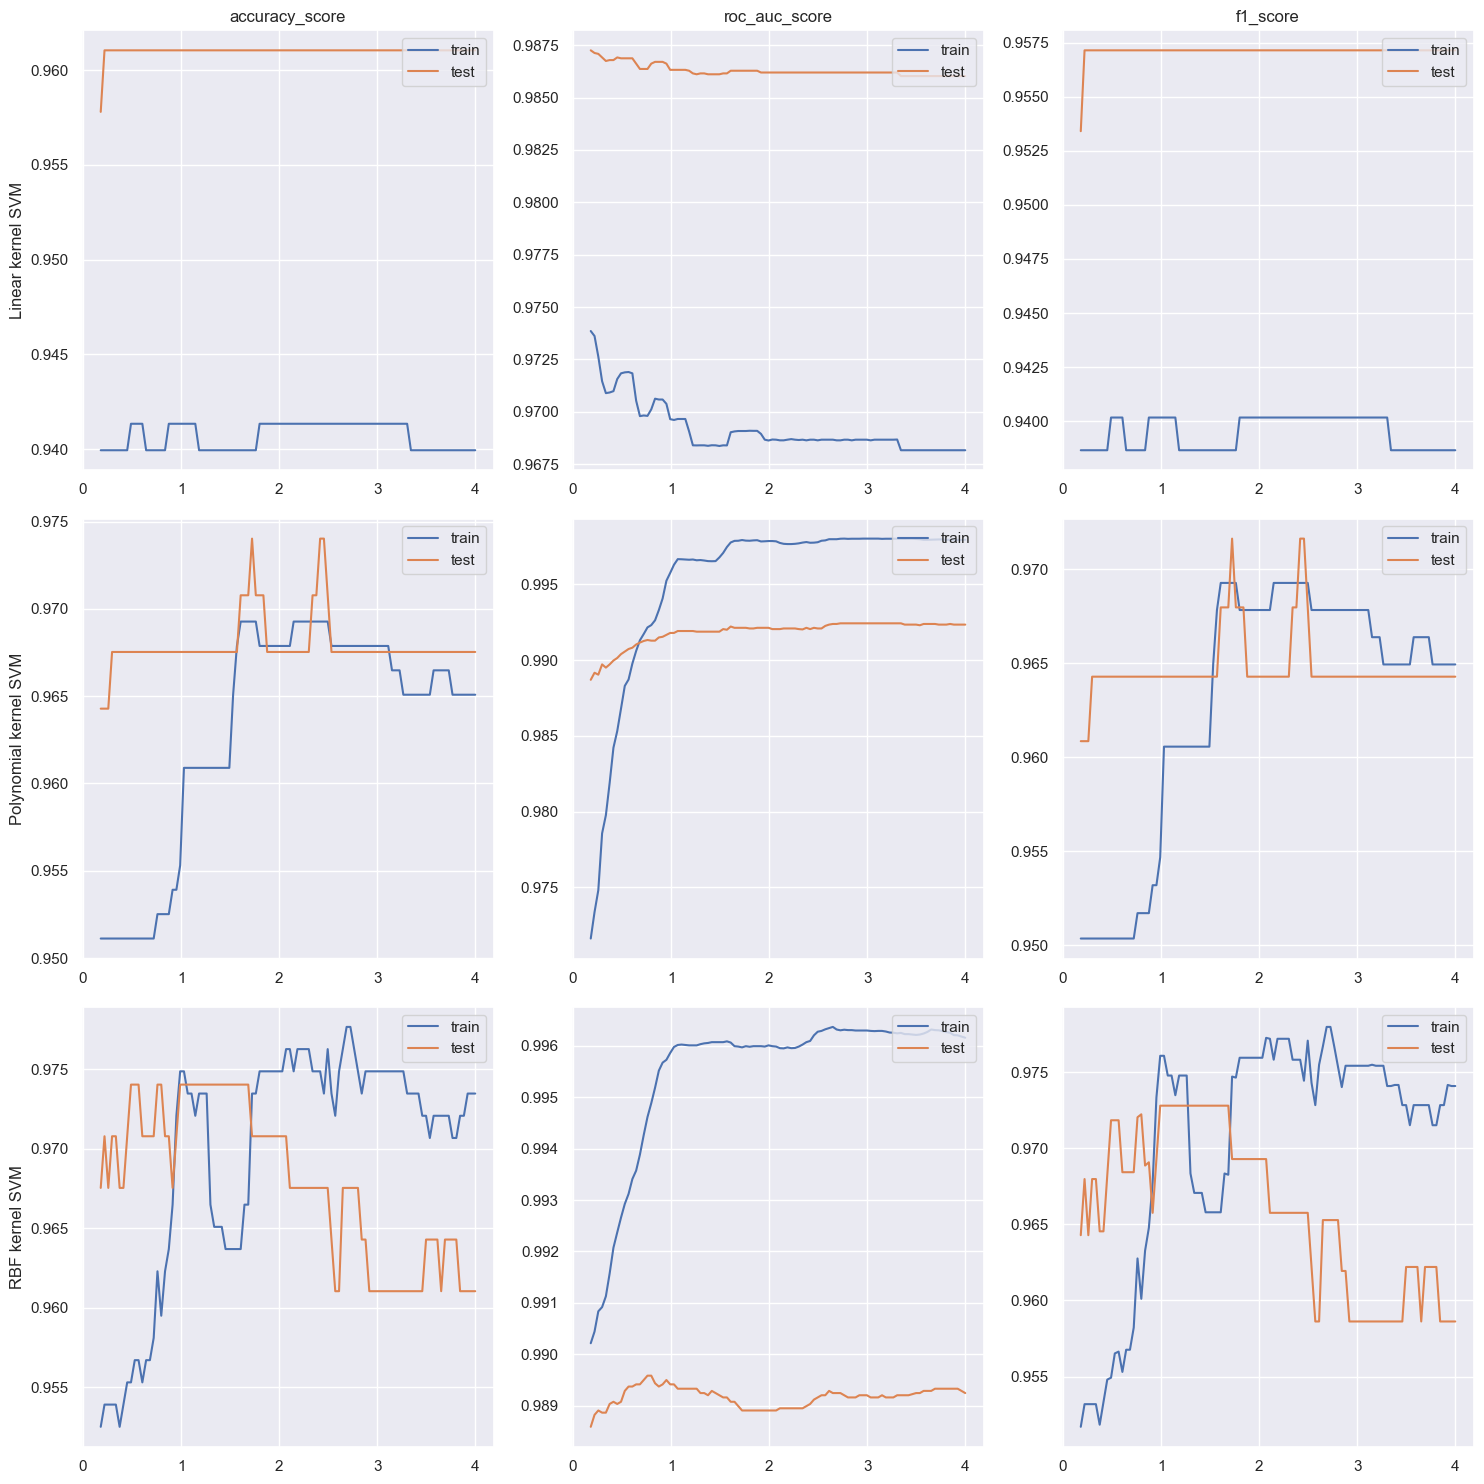

In [16]:
import matplotlib.pyplot as plt

#визуализация зависимости метрик от коэф регуляризации
SVM_scores_test, SVM_scores_train = [Linear_scores_test, Polynomial_scores_test, RBF_scores_test], [Linear_scores_train, Polynomial_scores_train, RBF_scores_train]
model_names, metric_names = ('Linear kernel SVM', 'Polynomial kernel SVM', 'RBF kernel SVM'), ('accuracy_score', 'roc_auc_score', 'f1_score')

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(metric_names[j]) 
        if j == 0:
            axs[i][j].set_ylabel(model_names[i]) 

        axs[i][j].plot(С_linspace, SVM_scores_train[i][:, j], label = 'train')
        axs[i][j].plot(С_linspace, SVM_scores_test[i][:, j], label = 'test')
        axs[i][j].legend(loc='upper right')

plt.tight_layout()
plt.show()


##### **Вывод:** Хоть и переобучаемость лучше оценивать по соотношению метрик для трейна и теста в зависимости от эпохи, для RBF ядра на графике видна антикорреляция значений метрик для трейна и теста (при улучшении метрик на трейне - падают значения метрик на тесте). Вообще, можно и логически понять, что RBF сколонен переобучаться больше, чем остальные ядра, тк он формирует более сложную зависимость для разделяющей гиперповерхности, чем полиномиальная и линейная, что в случае простых выборок, приводит к переобучению и снижению обобщающей способности алгоритма. Для графиков полиномиального ядра мы брали degree = 3 (по метрикам для данной выборки выбрано как лучшее значение: меньше - есть недообучение, выше - переобучение), но для больших degree рассуждения аналогичны - зависимость становится более сложной и есть склонность к переобучениею. Для параметра gamma лучше оставить дефолтное занчение - scale, впрочем, если изначально нормализовать данные, то зависимость от этого гиперараметра слабая. Коэфицент coef0 (свободный параметры для полинормиального ядра) при нормализации повышает значения метрик при значении 0.5, при его увеличении зависимость метрик от коэф регуляризации более неустойчивая. Зависимость для более сложных моделей (poly, rbf) от параметра регуляризации более сильная и неустойчивая, чем для линейной, тк они сильнее переобучаются и в большей степени нуждаются в регуляризации

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [ ]:
%pip install pymorphy3

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
%matplotlib inline

chosen_authors = ['Dostoevsky', 'Chekhov', 'Bryusov', 'Tolstoy', 'Herzen', 'Gogol']

In [19]:
import pickle

if os.path.exists('author2texts.pickle'):
    with open('author2texts.pickle', 'rb') as file:
        author2texts = pickle.load(file)
else:
    import nltk
    from nltk.corpus import stopwords
    from pymorphy3 import MorphAnalyzer
    import string
    import re

    nltk.download('stopwords')
    stop_words = set(stopwords.words('russian'))
    lemm = MorphAnalyzer()
    patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
    path_ = './prose'
    
    def extract_sentences(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = file.read()
            sentences = nltk.sent_tokenize(data)
            sentences = [re.sub(patterns, '', sentence.lower().translate(str.maketrans('', '', string.punctuation))) for sentence in sentences]
            sentences = [' '.join(lemm.normal_forms(word = word.strip())[0] for word in sentence.split() if word not in stop_words) for sentence in sentences]
            sentences = [sentence for sentence in sentences if len(sentence) > 20]
            print(file_path)
            return sentences[1:]
        
    text_buff_ = {author: [extract_sentences(os.path.join(path_, author, text)) for text in os.listdir(os.path.join(path_, author))] for author in chosen_authors}
    author2texts = {author: [sentence for text in texts for sentence in text] for author, texts in text_buff_.items()}

    with open('author2texts.pickle', 'wb') as file:
        pickle.dump(author2texts, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
from math import floor

prop_base = sorted([5000, 15000, 8000, 11000, 20000, 3000])

authors_lengths_dict = {author: len(sentences) for author, sentences in author2texts.items()}
authors_lengths_sorted = sorted(authors_lengths_dict.items(), key = lambda x: x[1])
print(*authors_lengths_sorted)

best_pr_coef = min([y/x for x, (_, y) in zip(prop_base, authors_lengths_sorted)])
prop_base = [floor(x * best_pr_coef) for x in prop_base]

author_proportion = {author: prop for prop, (author, _) in zip(prop_base, authors_lengths_sorted)}
print(author_proportion)

('Herzen', 8203) ('Chekhov', 16400) ('Gogol', 18980) ('Bryusov', 21540) ('Tolstoy', 75800) ('Dostoevsky', 91325)
{'Herzen': 5874, 'Chekhov': 9790, 'Gogol': 15665, 'Bryusov': 21540, 'Tolstoy': 29372, 'Dostoevsky': 39163}


In [21]:
author_sentence_pairs = [{'sentence': sentence, 'author': author} for author, sentences in author2texts.items() for sentence in sentences]
cleaned_dataset = pd.DataFrame(author_sentence_pairs)
cleaned_dataset = pd.concat([cleaned_dataset[cleaned_dataset['author']==author].sample(n=author_proportion[author], random_state=42) for author in author_proportion])
cleaned_dataset.groupby('author').count()

,sentence
author,
Bryusov,21540
Chekhov,9790
Dostoevsky,39163
Gogol,15665
Herzen,5874
Tolstoy,29372


In [22]:
cleaned_dataset.head()

,sentence,author
212412,начать защищать право ваш муж,Herzen
212672,душа открыться какаять пустота который предел ...,Herzen
210451,ценсура сделать разный урезывание вырезывание ...,Herzen
206087,час девятый утро нестройный кучка пожилой чело...,Herzen
207987,ненависть посмотреть бородка дырочка швырнуть ...,Herzen


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorized_sentences = vectorizer.fit_transform(cleaned_dataset['sentence'])

print(vectorized_sentences.shape, len(cleaned_dataset), len(vectorizer.get_feature_names_out()))

(121404, 54403) 121404 54403


#### После всех трансформаций мы имеем разреженную матрицу, где строки - это разреженные векторы соответсвующие предложению, а столбцы - токены или другими словами отвельные слова. Значения каждой компоненты вектора предложения определяется формулой $\text{tf-idf(t,d)}=\text{tf(d, t)} \times \text{idf(t)}$ (t - индекс токена, те столбец, d - индекс предложения, те строки (взято из <a href="https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting">link</a>)): 
$$\operatorname{idf}(t)=\log \frac{1+n}{1+\operatorname{df}(t)}+1 $$
#### tf(d, t) - частота токена t в предложении d, df(t) - частота токена во всех предложениях, n - число предложений. После составления данной разреженной матрицы каждый столбец для токена нормируется по L2 норме. То есть вектор-столбец для каждого токена - точка на единичной сфере пространства размерности n - числа предложений, в таком случае похожие вектора-столбцы характеризуются близким распределением tf-idf индекса по всем предложениям в смысле косинусного расстояния (или интуитивно часто встречаться в одних предложениях и как можно реже не пересекаться).

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [24]:
from scipy.sparse import vstack
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [25]:
y_total = np.array(cleaned_dataset['author'])

idxs_1 = (y_total == 'Tolstoy').nonzero()[0]
idxs_0 = (y_total == 'Dostoevsky').nonzero()[0][:len(idxs_1)]

y_0, y_1 = np.zeros(len(idxs_0)), np.ones(len(idxs_1))
X, y = vstack((vectorized_sentences[idxs_0], vectorized_sentences[idxs_1])), np.concatenate([y_0, y_1]).astype(np.uint8)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle= True, test_size=0.3)

In [26]:
if os.path.exists('log_grid_search.pickle'):
    with open('log_grid_search.pickle', 'rb') as file:
        log_grid_search = pickle.load(file)
else:
    params_grid = [{'C': np.linspace(0.1, 6, 20)}]
    log_grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), params_grid, verbose=4, cv=5, scoring='f1').fit(X_train, y_train)
    with open('log_grid_search.pickle', 'wb') as file:
        pickle.dump(log_grid_search, file, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
best_log_clf = log_grid_search.best_estimator_
log_grid_search.best_score_

0.8325285950320807

In [28]:
if os.path.exists('svc_grid_search.pickle'):
    with open('svc_grid_search.pickle', 'rb') as file:
        svc_grid_search = pickle.load(file)
else:
    params_grid = [{'kernel': ['linear'], 'C': np.linspace(0.5, 1.5, 5)}, {'kernel': ['rbf'], 'C': np.linspace(2.0, 5.0, 5)}]
    svc_grid_search = GridSearchCV(SVC(max_iter=5000, random_state=42), params_grid, verbose=4, cv=3, scoring='f1').fit(X_train, y_train)
    with open('svc_grid_search.pickle', 'wb') as file:
        pickle.dump(svc_grid_search, file, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
best_svc_clf = svc_grid_search.best_estimator_
svc_grid_search.best_score_

0.8147510410047544

In [30]:
cv_res = pd.DataFrame(svc_grid_search.cv_results_)
cv_res.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,26.997005,0.183374,10.114674,0.092876,0.5,linear,"{'C': 0.5, 'kernel': 'linear'}",0.805766,0.806449,0.808474,0.806896,0.001150,8
1,26.583244,0.151250,10.159648,0.252642,0.75,linear,"{'C': 0.75, 'kernel': 'linear'}",0.806355,0.806644,0.810229,0.807742,0.001762,6
2,27.670093,1.267034,10.324720,0.070435,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",0.805439,0.806716,0.804768,0.805641,0.000808,9
3,27.488212,0.914794,10.674530,1.151002,1.25,linear,"{'C': 1.25, 'kernel': 'linear'}",0.804025,0.811054,0.807015,0.807365,0.002880,7
4,28.238910,2.100119,10.260451,0.872148,1.5,linear,"{'C': 1.5, 'kernel': 'linear'}",0.803620,0.806953,0.805983,0.805519,0.001400,10
5,27.518157,0.216706,11.566844,0.325002,2.0,rbf,"{'C': 2.0, 'kernel': 'rbf'}",0.810271,0.817804,0.812900,0.813659,0.003122,2
6,29.578081,1.420258,12.687078,1.005178,2.75,rbf,"{'C': 2.75, 'kernel': 'rbf'}",0.812628,0.819806,0.811819,0.814751,0.003590,1
7,31.236297,3.549202,13.682043,2.644324,3.5,rbf,"{'C': 3.5, 'kernel': 'rbf'}",0.810511,0.813389,0.814717,0.812872,0.001756,4
8,27.569543,0.180678,12.696639,1.986214,4.25,rbf,"{'C': 4.25, 'kernel': 'rbf'}",0.812023,0.815313,0.812486,0.813274,0.001454,3
9,30.568225,0.985174,11.989578,0.534196,5.0,rbf,"{'C': 5.0, 'kernel': 'rbf'}",0.809277,0.812769,0.810445,0.810830,0.001451,5


[]

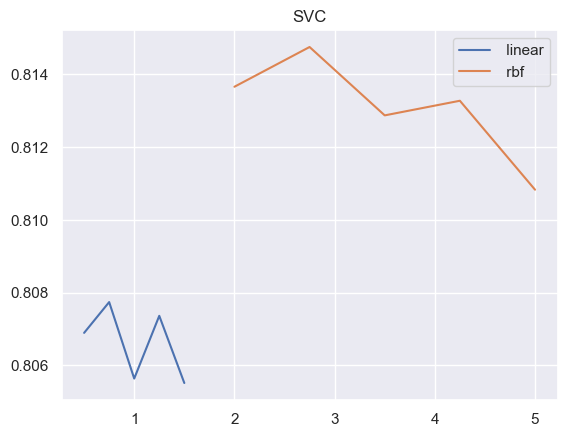

In [31]:
ker_ = np.array(cv_res['param_kernel'])
C_ = np.array(cv_res['param_C'])
scr_ = np.array(cv_res['mean_test_score'])

lin_idx, rbf_idx = (ker_ == 'linear'), (ker_ == 'rbf')
plt.plot(C_[lin_idx], scr_[lin_idx], label =' linear')
plt.plot(C_[rbf_idx], scr_[rbf_idx], label =' rbf')
plt.legend()
plt.title('SVC')
plt.plot()

[]

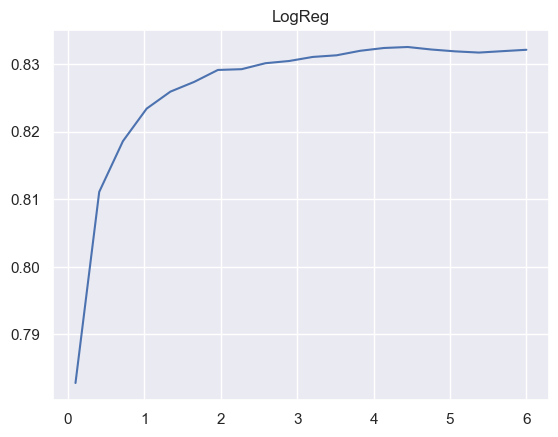

In [32]:
cv_res_ = log_grid_search.cv_results_
C, scr = cv_res_['param_C'], cv_res_['mean_test_score']
plt.plot(np.array(C), np.array(scr))
plt.title('LogReg')
plt.plot()

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from functools import partial

acc, roc_auc, f1 = partial(accuracy_score, y_test), partial(roc_auc_score, y_test), partial(f1_score, y_test)
print('SVC: ','acc', acc(best_svc_clf.predict(X_test)), 'f1', f1(best_svc_clf.predict(X_test)))
print('LogReg: ', 'acc', acc(best_log_clf.predict(X_test)), 'roc_auc', roc_auc(best_log_clf.predict_proba(X_test)[:, 1]), 'f1', f1(best_log_clf.predict(X_test)))

SVC:  acc 0.7997616886064458 f1 0.800587670226592
LogReg:  acc 0.8345438039037676 roc_auc 0.9184156878144286 f1 0.8329131331652533


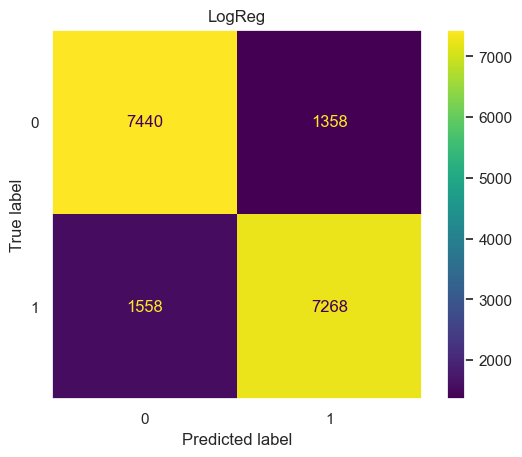

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_log_clf.predict(X_test), labels=best_log_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_log_clf.classes_)
disp.plot()
plt.title('LogReg')
plt.grid(False)
plt.show()

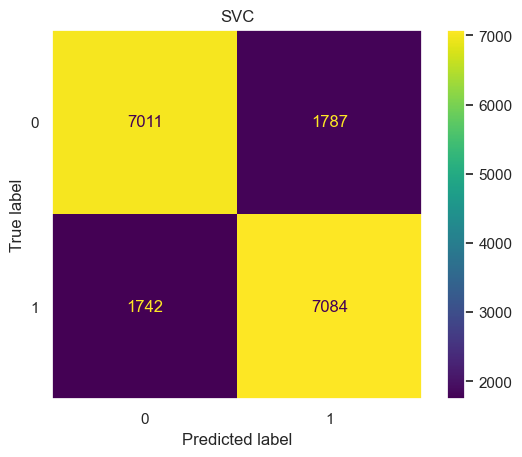

In [35]:
cm = confusion_matrix(y_test, best_svc_clf.predict(X_test), labels=best_svc_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svc_clf.classes_)
disp.plot()
plt.title('SVC')
plt.grid(False)
plt.show()

#### SVC в данном случае хуже по всем параметрам: он менее эффективен и медленно работает на большом датасете, где число объектов больше числа фичей. Также мы работаем с довольно шумными данными, в которых не исключены выбросы. Лог регрессия более подходит для этой задачи, и гораздо быстрей учится и более устойчива. Метрики получились сравнимые при полном балансе классов, но SVC очееень медленный

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

LogReg 0.3287332655520312
SVC -0.053269323142108874


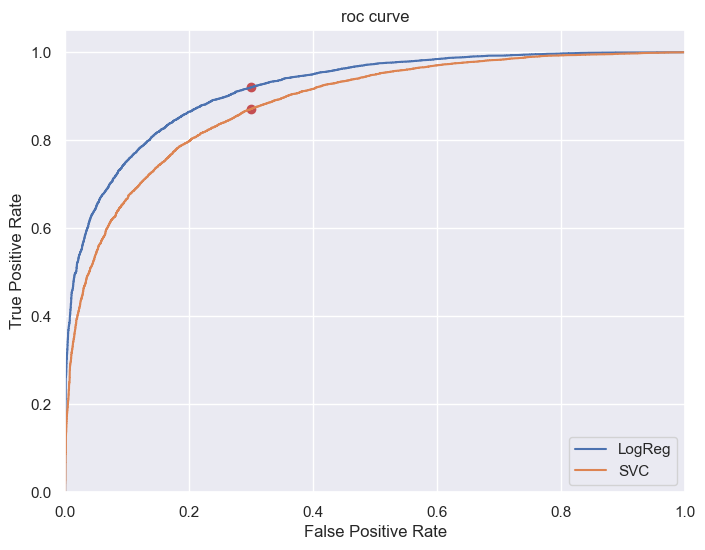

In [36]:
from sklearn import metrics

y_scores_logreg = best_log_clf.predict_proba(X_test)[:, 1]
y_scores_svc = best_svc_clf.decision_function(X_test)

fpr_logreg, tpr_logreg, thresholds_logreg = metrics.roc_curve(y_test, y_scores_logreg)
fpr_svc, tpr_svc, thresholds_svc = metrics.roc_curve(y_test, y_scores_svc)

idx_logreg = np.where(fpr_logreg <= 0.3)[0][-1]
threshold_logreg = thresholds_logreg[idx_logreg]
idx_svc = np.where(fpr_svc <= 0.3)[0][-1]
threshold_svc = thresholds_svc[idx_svc]

print('LogReg', threshold_logreg)
print('SVC', threshold_svc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label='LogReg')
plt.plot(fpr_svc, tpr_svc, label='SVC')
plt.scatter(fpr_logreg[idx_logreg], tpr_logreg[idx_logreg], color='r')
plt.scatter(fpr_svc[idx_svc], tpr_svc[idx_svc], color='r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc curve')
plt.legend(loc="lower right")
plt.show()

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [48]:
author2idx = {author: idx for idx, author in enumerate(chosen_authors)} 
X, y = vectorized_sentences, np.array(cleaned_dataset['author'].apply(lambda x: author2idx[x]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [49]:
if os.path.exists('multiclass_log_search.pickle'):
    with open('multiclass_log_search.pickle', 'rb') as file:
        multiclass_log_search = pickle.load(file)
else:
    params_grid = [{'solver': ['saga', 'lbfgs'], 'C': np.linspace(0.1, 7, 8)}]
    multiclass_log_search = GridSearchCV(LogisticRegression(max_iter=5000, random_state=42), params_grid, verbose=4, cv=3, scoring='f1_macro').fit(X_train, y_train)
    with open('multiclass_log_search.pickle', 'wb') as file:
        pickle.dump(multiclass_log_search, file, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
best_multi_log_clf = multiclass_log_search.best_estimator_

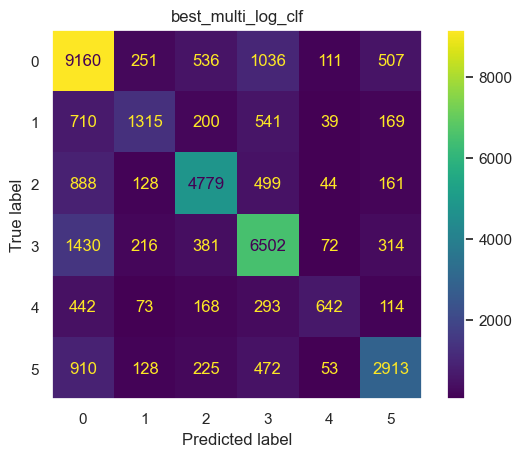

In [51]:
cm = confusion_matrix(y_test, best_multi_log_clf.predict(X_test), labels=best_multi_log_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_multi_log_clf.classes_)
disp.plot()
plt.title('best_multi_log_clf')
plt.grid(False)
plt.show()

In [52]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



y_pred = best_multi_log_clf.predict(X_test)

print('f1_score macro', f1_score(y_test, y_pred, average='macro'))
print('accuracy_score', accuracy_score(y_test, y_pred))
print('balanced_accuracy_score', balanced_accuracy_score(y_test, y_pred))
print('precision_score', precision_score(y_test, y_pred, average='macro'))

f1_score macro 0.6397499171450409
accuracy_score 0.6949371259129098
balanced_accuracy_score 0.6144590268897858
precision_score 0.6867565888256055


In [61]:
from sklearn.multiclass import OneVsOneClassifier

one_vs_one_est = OneVsOneClassifier(LogisticRegression(max_iter=5000, random_state=42, **multiclass_log_search.best_params_))
one_vs_one_est = one_vs_one_est.fit(X_train, y_train)
print(f1_score(y_test, one_vs_one_est.predict(X_test), average='macro'))

0.6237114656928785


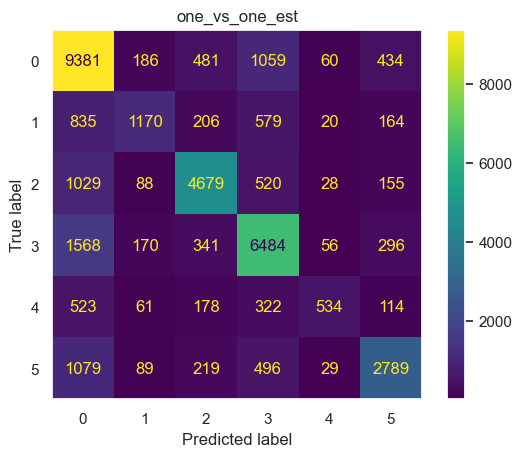

In [62]:
cm = confusion_matrix(y_test, one_vs_one_est.predict(X_test), labels=one_vs_one_est.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=one_vs_one_est.classes_)
disp.plot()
plt.title('one_vs_one_est')
plt.grid(False)
plt.show()

In [63]:
y_pred = one_vs_one_est.predict(X_test)

print('f1_score macro', f1_score(y_test, y_pred, average='macro'))
print('accuracy_score', accuracy_score(y_test, y_pred))
print('balanced_accuracy_score', balanced_accuracy_score(y_test, y_pred))
print('precision_score', precision_score(y_test, y_pred, average='macro'))

f1_score macro 0.6237114656928785
accuracy_score 0.6874142002086651
balanced_accuracy_score 0.5918182137638994
precision_score 0.7010414337859489
